# Metropolis-adjusted Langevin algorithm (MALA)

This is a final example for the workshop to show how to put all the concepts we talked about together. Because this is meant to be read after the rest of the notebooks I will not comment on the meaning nor the syntax of the JAX primitives used here, and rather redirect to the individual notebooks (or obviously the [official JAX documentation](https://jax.readthedocs.io/en/latest/)) for more information.

In [33]:
from jax import jit, grad, vjp
from jax.random import PRNGKey, normal, uniform, split
from jax.lax import scan, cond
import jax.numpy as jnp

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

### Problem statement

In this notebook we use a simple squashed 2D normal distribution as a target.
The goal is not to illustrate the efficiency of MALA over Metropolis-Hastings (MH), nor to explain what they do or why they work (anyone interested in the theory of MCMC could for example check the [Handbook of MCMC](https://www.routledgehandbooks.com/doi/10.1201/b10905-7) by Neal Radford), 
but rather to give an example of a comprehensive routine involving loops/gradients/if-else/randomness 
as a reference/guide for future implementations. I am obviously not claiming to have implemented here the "best" version
of either algorithms, but a "good enough" overview of how it could be done.

In [176]:
key = PRNGKey(42)
x0 = jnp.ones(2)
N = 10000
K = 500


def target_loglik(z): 
    arr = jnp.array([1., 5.])
    y = arr * z
    return -jnp.inner(y, y) / 2

def proposal_sampler(k, z):
    return z + normal(k, shape=z.shape)

### MH

Metropolis-Hastings is a gradient free Markov chain Monte Carlo method to sample from an unnormalised distribution. 
It could roughly be seen as a generalisation of the Von Neumann accept-reject algorithm to distributions where the normalising constant is unknown.
The informed reader may have noticed that we actually implement the Metropolis (symmetric) original algorithm instead of the "real" MH one. 
This is mostly to keep the code clear and could easily be added by the interested user.

In [187]:
def mh(key, target_loglikelihood, x0, proposal_sampler, n=10000):
    logp0 = target_loglikelihood(x0)
    
    keys = split(key, n + 1)
    logus = jnp.log(uniform(keys[0], shape=(n,)))

    def body(carry, inp):
        prev_x, prev_logp = carry
        k, logu = inp
        proposed_x = proposal_sampler(k, prev_x)
        proposed_logp = target_loglikelihood(proposed_x)
        
        accept_predicate = logu < proposed_logp - prev_logp
        next_x, next_loglik = cond(accept_predicate, 
                                   lambda _: (proposed_x, proposed_logp),
                                   lambda _: (prev_x, prev_logp),
                                   operand=None)
        
        return (next_x, next_loglik), (next_x, accept_predicate)
    
    _, (samples, acc) = scan(body, (x0, logp0), (keys[1:], logus))
    return samples, acc

mh_samples, acc_rate = mh(key, target_loglik, x0, proposal_sampler, n=N)

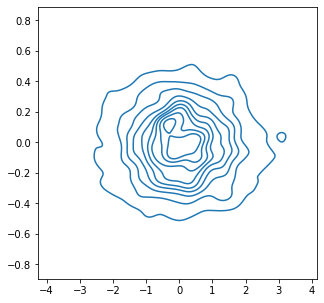

In [188]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.kdeplot(x=mh_samples[K:, 0], y=mh_samples[K:, 1], ax=ax)


### MALA

On the other hand MALA is a variant of the MH algorithm where the proposal distribution is adapted to the geometry of the log-likelihood potential through its gradient (in technical terms, this means that the proposal follows the so called Langevin dynamics).

In [178]:
def mala(key, target_loglikelihood, x0, n=10000, step_size=1e-2):
    x0 = jnp.asarray(x0)
    logp0, logp0_grad_fun = vjp(target_loglikelihood, x0)
    logp0_grad = logp0_grad_fun(1.)[0]
    keys = split(key, 2)
    logus = jnp.log(uniform(keys[0], shape=(n,)))
    noises = jnp.sqrt( 2 * step_size) * normal(keys[1], shape=(n, x0.shape[0]))

    def log_proposal_loglik(y, z, grad_logp):
        diff = z - y - step_size * grad_logp
        return -0.25 * jnp.inner(diff, diff) / step_size
    
    def acceptance_ratio(prev_x, prev_logp, prev_logp_grad,
                         proposed_x, proposed_logp, proposed_log_grad):
        num = proposed_logp + log_proposal_loglik(proposed_x, prev_x, proposed_log_grad)
        den = prev_logp + log_proposal_loglik(prev_x, proposed_x, prev_logp_grad)
        return num - den
    
    def body(carry, inp):
        prev_x, prev_logp, prev_logp_grad = carry
        noise, logu = inp
        
        proposed_x = prev_x + step_size * prev_logp_grad + noise
        proposed_logp, proposed_logp_grad_fun = vjp(target_loglikelihood, proposed_x)
        proposed_logp_grad = proposed_logp_grad_fun(1.)[0]
        
        accept_predicate = logu < acceptance_ratio(prev_x, prev_logp, prev_logp_grad, 
                                                   proposed_x, proposed_logp, proposed_logp_grad)
        next_x, next_loglik, next_grad = cond(accept_predicate, 
                                              lambda _: (proposed_x, proposed_logp, prev_logp_grad),
                                              lambda _: (prev_x, prev_logp, proposed_logp_grad),
                                              operand=None)
        
        return (next_x, next_loglik, next_grad), (next_x, accept_predicate)
    
    _, (samples, acceptance) = scan(body, (x0, logp0, logp0_grad), (noises, logus))
    return samples, acceptance

mala_samples, acc_rate = mala(key, target_loglik, jnp.zeros(2), step_size=1e-2)

/u/95/corenfa1/unix/PycharmProjects/jax-workshop/venv/lib/python3.7/site-packages/seaborn/distributions.py:1184: UserWarning: The following kwargs were not used by contour: 'kind'
  **contour_kws,


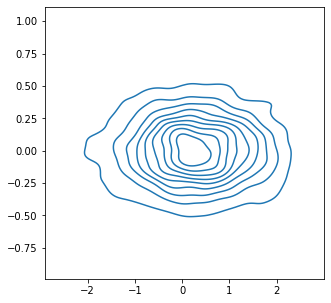

In [186]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = sns.kdeplot(x=mala_samples[K:, 0], y=mala_samples[K:, 1], kind="kde", ax=ax)

In [191]:
from jaxlib import __version__

In [192]:
__version__

'0.1.56'